##### This is an adaptation of the Iris linear regresion from
##### "https://github.com/FluxML/model-zoo/blob/master/other/iris/iris.jl"
##### 1. Get the Churn_Modelling.csv
##### url = "https://github.com/selva86/datasets/blob/master/Churn_Modelling.csv"

In [1]:
using Pkg

In [2]:
using CSV, DataFrames, Flux, Downloads, Statistics, Plots
using Flux: logitcrossentropy, normalise, onecold, onehotbatch
using Statistics: mean
using Random

In [3]:
# Descarga del archivo de datos CSV
url = "https://raw.githubusercontent.com/selva86/datasets/refs/heads/master/Churn_Modelling.csv"
file = "../dat/Churn_Modelling.csv"
Downloads.download(url, file)

# Leer el archivo CSV
df = CSV.read(file, DataFrame)

# Mostrar los nombres de la cabecera, asi como las dimensiones del dataset.
@show names(df)
@show size(df);

names(df) = ["RowNumber", "CustomerId", "Surname", "CreditScore", "Geography", "Gender", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Exited"]
size(df) = (10000, 14)


In [4]:
# A continuación utilizo la función describe para poder identificar el tipo de datos que contiene el dataset, así como información extra sobre las variables.
describe(df)
#GC.gc()


14×7 DataFrame
 Row │ variable         mean       min       median     max        nmissing  e ⋯
     │ Symbol           Union…     Any       Union…     Any        Int64     D ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ RowNumber        5000.5     1         5000.5     10000             0  I ⋯
   2 │ CustomerId       1.56909e7  15565701  1.56907e7  15815690          0  I
   3 │ Surname                     Abazu                Zuyeva            0  S
   4 │ CreditScore      650.529    350       652.0      850               0  I
   5 │ Geography                   France               Spain             0  S ⋯
   6 │ Gender                      Female               Male              0  S
   7 │ Age              38.9218    18        37.0       92                0  I
   8 │ Tenure           5.0128     0         5.0        10                0  I
   9 │ Balance          76485.9    0.0       97198.5    2.50898e5         0  F ⋯
  10 │ NumOfProducts    1.5302     1         1.0        4                 0  I
  11 │ HasCrCard        0.7055     0         1.0        1                 0  I
  12 │ IsActiveMember   0.5151     0         1.0        1                 0  I
  13 │ EstimatedSalary  1.0009e5   11.58     1.00194e5  1.99992e5         0  F ⋯
  14 │ Exited           0.2037     0         0.0        1                 0  I
                                                                1 column omitted

In [5]:
unique_countries = unique(df.Geography)
# Mostrar los países únicos
# Contar la cantidad de países únicos
num_countries = length(unique_countries)
println("Lista de Países: ", unique_countries)
println("Número de países únicos: ", num_countries)
unique_gender = unique(df.Gender)
genders = length(unique_gender);

Lista de Países: String7["France", "Spain", "Germany"]
Número de países únicos: 3


# Preprocesar datos

In [6]:

#function preprocess_data(df::DataFrame)
# La traducción de "Churn" hace referencia a la rotación de clientes.
# Estos datos parecen pertenecer a un dataset de clientes bancarios, utilizado para predecir si un cliente de un banco 
# abandonará o no el servicio. Por ello, se tomará la columna "Exited" (cuyos valores son 0 o 1) como la variable binaria dependiente a predecir.

# Las variables de identificacion del cliente no son reelevantes por lo que se eliminaran del dataset
cols_to_drop_0 = [ :RowNumber, :Surname, :CustomerId]
df_cleaned = select(df, Not(cols_to_drop_0))

# Por otro lado las columnas Gender y Geography son variables categoricas. 
gender_onehot = Flux.onehotbatch(df.Gender, ["Male", "Female"])
# Ejemplo para Geography
geography_onehot = Flux.onehotbatch(df.Geography, unique(df.Geography))
# Transponer las nuevas columnas OneHot para que corresponda con las dimensiones del dataframe
gender_onehot = transpose(gender_onehot)
geography_onehot = transpose(geography_onehot)

#Convertir las matrices One-Hot a vectores para cada columna
# Para Gender, tendremos dos columnas, una para "Male" y otra para "Female"
df_cleaned[!, "Gender_Male"] = Int.(gender_onehot[:, 1])
df_cleaned[!, "Gender_Female"] = Int.(gender_onehot[:, 2])

# Para Geography, tendremos tantas columnas como países haya en "Geography"
for (i, country) in enumerate(unique(df.Geography))
    df_cleaned[!, "Geography_$(country)"] = Int.(geography_onehot[:, i])
end

# Eliminamos las columnas originales "Gender" y "Geography"
cols_to_drop_1 = [ :Gender, :Geography]
df_cleaned = select(df_cleaned, Not(cols_to_drop_1));

In [7]:
# We set default values for the learning rate *lr* (for the training routine) and the number of
# times that we repeat the train data (more information below):

Base.@kwdef mutable struct Args
    lr::Float64 = 0.5
    repeat::Int = 110
end

# Defino el DataFrame como Matriz
A = Matrix(df_cleaned)
Exited = A[:,9]
A = hcat(A[:, 1:8], A[:, 10:end], Exited) ; # Muevo la columna Exited al final
@show size(A)

size(A) = (10000, 14)


(10000, 14)

In [19]:
function perclass_splits(y,at)
    uids = unique(y)
    keepids = []
    for ui in uids
        curids = findall(y.==ui)
        rowids = randsubseq(curids, at) 
        push!(keepids,rowids...)
    end
    return keepids
end




# Función para obtener los datos procesados
function get_data(args::Args, at)
    X = A[:, 1:end-1]  # Todas las columnas excepto la última (independientes)
    y = A[:, end]      # La última columna (dependiente)

    # Normalización
    X_norm = transpose(normalise(X, dims=1))
    println("x_norm: ", size(X_norm))
    y_oneHot = onehotbatch(y, [0, 1])
    println("y", size(y_oneHot))

    # Dividir aleatoriamente los índices en 70% para entrenamiento y 30% para prueba
    trainids = perclass_splits(y, at);
    testids = setdiff(1:length(y),trainids);
    
    println("train", size(trainids), size(testids))
    # Dividir en entrenamiento y prueba usando los índices seleccionados
    X_train = X_norm[:, trainids]
    y_train = y_oneHot[:, trainids]
    X_test = X_norm[:, testids]
    y_test = y_oneHot[:, testids]

    println("sizes train x y", size(X_train), size(y_train))
    println("sizes test x y", size(X_test), size(y_test))
    # Convertir a Float32
    X_train = Float32.(X_train)
    X_test = Float32.(X_test)
    

    # Repetir los datos de entrenamiento `args.repeat` veces
    train_data = Iterators.repeated((X_train, y_train), args.repeat)
    test_data = (X_test, y_test)

    return X_train, y_train, X_test, y_test
end



get_data (generic function with 1 method)

x_norm: (13, 10000)
y(2, 10000)
train(7974,)(2026,)
sizes train x y(13, 7974)(2, 7974)
sizes test x y(13, 2026)(2, 2026)
x_train(13, 7974)
Iniciando entrenamiento.

Precisión: 0.8018262586377097

Matriz de confusión:

Curva ROC:
Área bajo la curva (AUC): 0.7986179664363278


2×2 Matrix{Int64}:
 1632   394
  394  1632

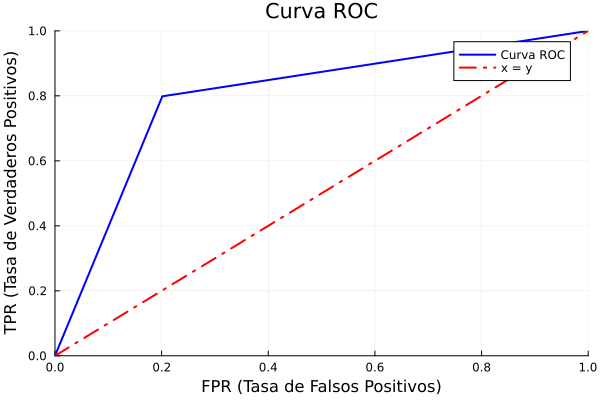

In [21]:
# Métricas: precisión y matriz de confusión
accuracy(model, x, y) = mean((model(x) .> 0.5) .== y)
#accuracy(model, x, y) = mean(onecold(model(x)) .== y)

function confusion_matrix(model, X, y)
    ŷ = onehotbatch(onecold(model(X)), 1:2)
    y * transpose(ŷ)
        # Verdaderos positivos (TP), Falsos positivos (FP), Falsos negativos (FN), Verdaderos negativos (TN)
        TP = sum((ŷ .== 1) .& (y .== 1))  # Predicción 1 y realidad 1
        FP = sum((ŷ .== 1) .& (y .== 0))  # Predicción 1 y realidad 0
        FN = sum((ŷ .== 0) .& (y .== 1))  # Predicción 0 y realidad 1
        TN = sum((ŷ .== 0) .& (y .== 0))  # Predicción 0 y realidad 0
        return [TN FP; FN TP]
end


# Función para calcular la Curva ROC y AUC
function calculate_roc(ground_truth, predictions_prob, n)
    thresholds = LinRange(0, 1, n)  # Umbrales posibles de predicción
    TPR = Float64[]  # Tasa de verdaderos positivos (Recall)
    FPR = Float64[]  # Tasa de falsos positivos
    auc = 0.0  # Área bajo la curva (AUC)

    # Calcular TPR y FPR para cada umbral
    for threshold in thresholds
        # Predicción binaria con el umbral
        predictions = predictions_prob .>= threshold

        # Calcular los valores de TP, FP, FN y TN
        TP = sum((predictions .== 1) .& (ground_truth .== 1))
        FP = sum((predictions .== 1) .& (ground_truth .== 0))
        FN = sum((predictions .== 0) .& (ground_truth .== 1))
        TN = sum((predictions .== 0) .& (ground_truth .== 0))

        # Calcular TPR (Recall) y FPR
        push!(TPR, TP / (TP + FN))
        push!(FPR, FP / (FP + TN))
    end
    # Ordenar FPR y TPR en orden ascendente de FPR para el cálculo correcto del AUC
    sorted_indices = sortperm(FPR)
    FPR = FPR[sorted_indices]
    TPR = TPR[sorted_indices]

    # Calcular AUC usando la regla de los trapecios (trapezoidal rule)
    auc = sum(diff(FPR) .* (TPR[1:end-1] .+ TPR[2:end]) / 2)

    # Graficar la curva ROC
    p = plot(FPR, TPR, label="Curva ROC", xlabel="FPR (Tasa de Falsos Positivos)", 
    ylabel="TPR (Tasa de Verdaderos Positivos)", title="Curva ROC", linewidth=2, color=:blue, )
    plot!(xlims=(0, 1), ylims=(0, 1))  # Límites de los ejes de la gráfica
    plot!(grid=true, legend=:topright, linewidth=2, 
    linestyle=:dashdot)  # Leyenda en la esquina superior derecha
    # Identidad
    x = 0:0.1:10
    plot!(x, x, label="x = y", linestyle=:dashdot, color=:red, linewidth=2)

    # Forzar la visualización del gráfico
   
    display(p)
    println("Área bajo la curva (AUC): ", auc) 

    return FPR, TPR, auc
end;


# Función de entrenamiento
function train(at::Float64; kws...)
    args = Args(; kws...)
    
    X_train, y_train, X_test, y_test = get_data(args, at)  # Usando la matriz A
    println("x_train", size(X_train))
    # Crear el modelo de regresión logística
    model = Chain(
        Dense(13, 64, relu), 
        Dense(64, 2, sigmoid))  # Usamos el número de características como input_size

    # Función de pérdida
    loss(m, x, y) = logitcrossentropy(m(x), y)
    
    # Optimización
    optimiser = Descent(args.lr)
    
    println("Iniciando entrenamiento.")
    Flux.train!(loss, model, Iterators.repeated((X_train, y_train), args.repeat), optimiser)
    
    return model, (X_test, y_test)
end


# Función de prueba
function test(model, test, n::Int64)
    X_test, y_test = test
    
    # Precisión
    accuracy_score = accuracy(model, X_test, y_test)
    println("\nPrecisión: $accuracy_score")
    
    # Matriz de confusión
    println("\nMatriz de confusión:")
    display(confusion_matrix(model, X_test, y_test))

    #Predicciones del modelo: obtener probabilidades de clase 1
    predictions_prob = model(X_test)[:, 2]  # Seleccionar las probabilidades de la clase 1 (columna 2)
       
    # Curva ROC
    println("\nCurva ROC:")
    roc = calculate_roc(y_test, predictions_prob, n)
    
end
# Ejecutar el entrenamiento y prueba
cd(@__DIR__);
model, test_data = train(0.8);
test(model, test_data, 30000);
